# Detect pair trading opportunities using ML (clustering) and statistical methods

Traders who are particuarly keen on Pairs Trading, need a way to find pairs that:
    
    a) Are similar in risk and behaviour
    b) Are cointegrated

I will use K-means clustering to group etfs with similar annual return and volatility. 
Then I have cointegration calculations run against them to further help with statistical methods.

### Imports

In [110]:
# Remove unwanted warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data extraction and management
import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols

# Feature Engineering
from sklearn.preprocessing import StandardScaler

# Machine Learning
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator

# Cointegration and Statistics
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Reporting visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns; sns.set(style="whitegrid")
%matplotlib inline

### Data Extraction

In [2]:
symbols = get_nasdaq_symbols()
# for common NASDAQ GLOBAL MARKET stock with normal(default) financial status
symbols = symbols[(symbols["ETF"] == False) & (symbols["Market Category"] == 'G') & (symbols["Test Issue"]==False) & (symbols["Financial Status"]=='N')] 
symbols = list(symbols.index.values)
symbols = [str(i) for i in symbols]

In [3]:
# Load Data
start_date = "2018-01-01"
end_date = "2022-12-30"
data = yf.download(symbols, start=start_date, end=end_date)["Adj Close"]

[*********************100%***********************]  1205 of 1205 completed

248 Failed downloads:
- GLLIR: No data found for this date range, symbol may be delisted
- PCCTW: No data found for this date range, symbol may be delisted
- FTIIW: No data found for this date range, symbol may be delisted
- AVHIW: No data found for this date range, symbol may be delisted
- CNGLW: No data found for this date range, symbol may be delisted
- GIACW: No data found for this date range, symbol may be delisted
- STRCW: No data found for this date range, symbol may be delisted
- ALSAR: No data found for this date range, symbol may be delisted
- SLACU: Data doesn't exist for startDate = 1514782800, endDate = 1672376400
- GFGDR: No data found for this date range, symbol may be delisted
- IVCPW: No data found for this date range, symbol may be delisted
- ENERW: No data found for this date range, symbol may be delisted
- SPCMW: No data found for this date range, symbol may be delisted
- THCPW: No data foun

In [4]:
# Load (or re-load for consistency) Data and remove features with NaN's
data.dropna(axis=1, inplace=True)
print("Shape: ", data.shape)
print("Null Values: ", data.isnull().values.any())
data.head()

Shape:  (1258, 282)
Null Values:  False


,AACG,AAME,AAOI,ACIU,ACMR,ACNT,ACRX,ADES,ADMA,AFMD,...,WLDN,WLFC,WVE,XENE,XNCR,XOMA,ZIONL,ZIONO,ZIONP,ZLAB
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02 00:00:00,0.073676,3.170325,37.910000,13.35,1.873333,13.45,41.000000,7.758869,3.30,1.375,...,23.330000,25.580000,34.799999,2.875,22.799999,35.919998,24.315695,20.282089,23.299999,22.260000
2018-01-03 00:00:00,0.072455,3.267873,37.889999,13.14,1.766667,13.55,42.000000,7.685362,3.21,1.400,...,22.570000,25.639999,34.799999,2.950,22.920000,35.849998,24.315695,20.334225,23.833900,22.350000
2018-01-04 00:00:00,0.073269,3.170325,38.380001,13.06,1.771667,13.55,41.000000,7.660861,3.29,1.500,...,23.170000,25.760000,34.799999,3.000,23.160000,33.830002,24.404518,20.334225,24.268400,22.100000
2018-01-05 00:00:00,0.073269,3.560519,38.889999,13.04,1.836667,13.38,43.400002,7.554687,3.23,1.375,...,23.520000,26.260000,33.549999,2.925,22.830000,34.360001,24.517582,20.371466,24.473200,22.809999
2018-01-08 00:00:00,0.071505,3.267873,38.369999,12.94,1.746667,13.47,42.599998,7.464848,3.30,1.300,...,23.530001,25.959999,32.549999,2.900,22.379999,32.810001,24.275312,20.371466,24.450001,22.980000


### Feature Engineering

In [5]:
# Create DataFrame with annually Returns and Volatility information (annual trading days =252)
df_returns = pd.DataFrame(data.pct_change().mean() * 252, columns=["Returns"])
df_returns["Volatility"] = data.pct_change().std() * np.sqrt(252)
df_returns.head()

,Returns,Volatility
AACG,3.682301,5.344749
AAME,0.292501,0.929854
AAOI,-0.333777,0.730602
ACIU,-0.015139,0.820811
ACMR,0.660091,0.875433


In [6]:
# Scale Features
scaler = StandardScaler()
scaler = scaler.fit_transform(df_returns)
scaled_data = pd.DataFrame(scaler, columns=df_returns.columns, index=df_returns.index)
df_scaled = scaled_data
df_scaled.head()

,Returns,Volatility
AACG,9.592484,8.993930
AAME,0.217673,0.450155
AAOI,-1.514359,0.064559
ACIU,-0.633136,0.239134
ACMR,1.234278,0.344839


### K-Means Clustering

In [7]:
# Find the optimum number of clusters
X = df_scaled.copy()
K = range(1, 15)
distortions = []
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)
    
kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
c = kl.elbow
print("Optimum Clusters: ", c)

Optimum Clusters:  3


In [8]:
# Fit K-Means Model
k_means = KMeans(n_clusters=c)
k_means.fit(X)
prediction = k_means.predict(df_scaled)

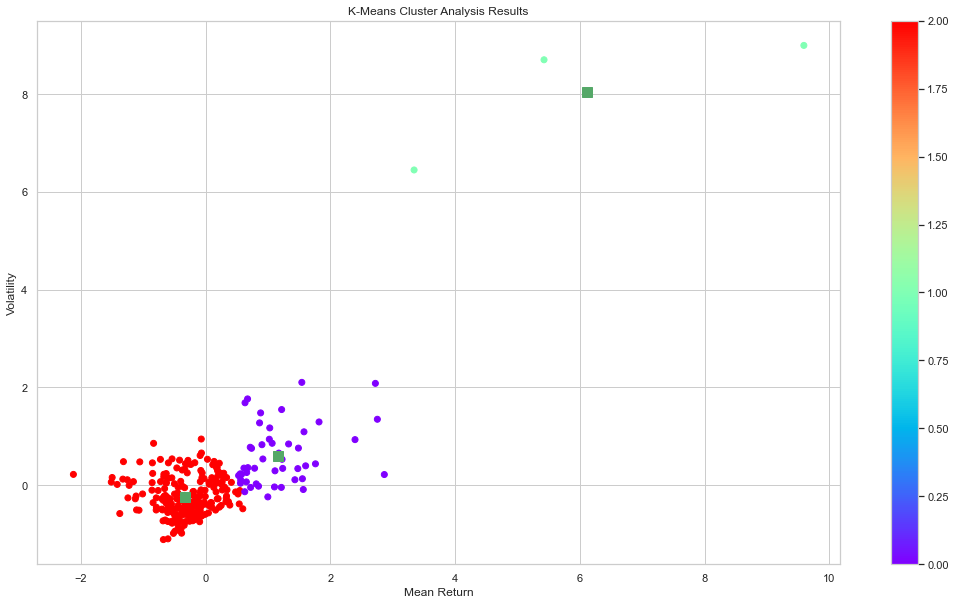

In [111]:
# Show Results
centroids = k_means.cluster_centers_
fig = plt.figure(figsize = (18, 10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=k_means.labels_, cmap="rainbow", label=X.index)
ax.set_title("K-Means Cluster Analysis Results")
ax.set_xlabel("Mean Return")
ax.set_ylabel("Volatility")
plt.colorbar(scatter)
plt.plot(centroids[:,0], centroids[:,1], "sg", markersize=10)
plt.show()

In [10]:
# Return the series
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series[:5]

AACG    1
AAME    2
AAOI    2
ACIU    2
ACMR    0
dtype: int32

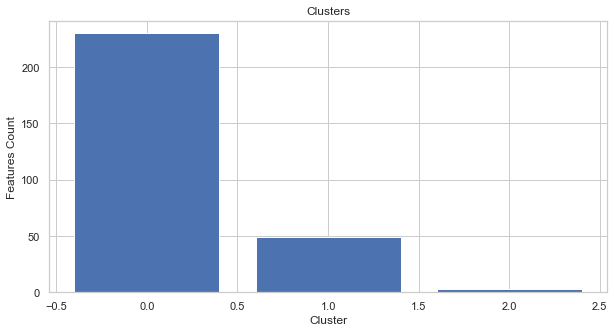

In [112]:
# View number by cluster
plt.figure(figsize=(10, 5))
plt.bar(range(len(clustered_series.value_counts())), clustered_series.value_counts())
plt.title("Clusters")
plt.xlabel("Cluster")
plt.ylabel("Features Count")
plt.show()

In [12]:
# Remove Items if Preferred
clusters_clean = clustered_series[clustered_series < 2]
print("Feature Number Previous: ", len(clustered_series))
print("Feature Number Current: ", len(clusters_clean))

Feature Number Previous:  282
Feature Number Current:  52


### Calculate Cointegration, Hedge Ratio and Correlation

#### Testing for Cointegration

The steps in the cointegration test procdure:

1. Test for a unit root in each component series $y_{t}$ individually, using the univariate unit root tests, say ADF, PP test.
2. If the unit root cannot be rejected, then the next step is to test cointegration among the components, i.e., to test whether $\alpha Y_{t}$ is I(0).

If we find that the time series as a unit root, then we move on to the cointegration process. There are three main methods for testing for cointegration: Johansen, Engle-Granger, and Phillips-Ouliaris. We will primarily use the Engle-Granger test.

Let's consider the regression model for $y_{t}$:

$$y_{1t} = \delta D_{t} + \phi_{1t}y_{2t} + \phi_{m-1} y_{mt} + \varepsilon_{t} $$

$D_{t}$ is the deterministic term. From there, we can test whether $\varepsilon_{t}$ is $I(1)$ or $I(0)$. The hypothesis test is as follows:

$$
\begin{aligned}
H_{0} & :  \varepsilon_{t} \sim I(1) \implies y_{t} \ (no \ cointegration)  \\
H_{1} & : \varepsilon_{t} \sim I(0) \implies y_{t} \ (cointegration)  \\
\end{aligned}
$$

$y_{t}$ is cointegrated with a *normalized cointegration vector* $\alpha = (1, \phi_{1}, \ldots,\phi_{m-1}).$

We also use residuals $\varepsilon_{t}$ for unit root test.

$$
\begin{aligned}
H_{0} & :  \lambda = 0 \ (Unit \ Root)  \\
H_{1} & : \lambda < 1 \ (Stationary)  \\
\end{aligned}
$$

This hypothesis test is for the model:

$$\Delta\varepsilon_{t}=\lambda\varepsilon_{t-1}+\sum^{p-1}_{j=1}\varphi\Delta\varepsilon_{t-j}+\alpha_{t}$$

The test statistic for the following equation:

$$t_{\lambda}=\frac{\hat{\lambda}}{s_{\hat{\lambda}}} $$

Now that you understand what it means for two time series to be cointegrated, we can test for it and measure it using python:

In [13]:
# Calculate cointegration
def calculate_cointegration(series_1, series_2):
    coint_flag = 0
    coint_res = coint(series_1, series_2)
    coint_t = coint_res[0]
    p_value = coint_res[1]
    critical_value = coint_res[2][1]
    model = sm.OLS(series_1, sm.add_constant(series_2)).fit()
    hedge_ratio = model.params[1]
    coint_flag = 1 if p_value < 0.05 and coint_t < critical_value else 0
    return coint_flag, hedge_ratio

In [14]:
# Loop through and calculate cointegrated pairs
# Allow 10 - 30 mins for calculation 
tested_pairs = []
cointegrated_pairs = []

for base_asset in clusters_clean.index:
    base_label = clusters_clean[base_asset]       

    for compare_asset in clusters_clean.index:
        compare_label = clusters_clean[compare_asset]
        
        test_pair = base_asset + compare_asset
        test_pair = ''.join(sorted(test_pair))
        is_tested = test_pair in tested_pairs
        tested_pairs.append(test_pair)
        
        if compare_asset != base_asset and base_label == compare_label and not is_tested:
            
            series_1 = data[base_asset].values.astype(float)
            series_2 = data[compare_asset].values.astype(float)
            coint_flag, hedge_ratio = calculate_cointegration(series_1, series_2)
            corr = data[base_asset].corr(data[compare_asset])
            if coint_flag == 1:
                cointegrated_pairs.append({"base_asset": base_asset, 
                                            "compare_asset": compare_asset, 
                                            "correlation": corr,
                                            "hedge_ratio": hedge_ratio,
                                            "label": base_label})
                
df_coint = pd.DataFrame(cointegrated_pairs).sort_values(by="label")
    

In [15]:
#pd.set_option('display.max_rows', None)
df_coint.head()

,base_asset,compare_asset,correlation,hedge_ratio,label
66,AMTX,MNKD,0.797431,3.535565,0
97,IMMP,SYPR,0.778468,0.727697,0
96,IMMP,PTGX,0.619645,0.049237,0
95,IMMP,NTLA,0.738783,0.016274,0
94,IMMP,MVIS,0.723759,0.125953,0


In [16]:
df_pair = df_coint[df_coint['correlation']>0.8]
df_pair = df_pair.sort_values('correlation',ascending=False)
df_pair = df_pair.reset_index(drop=True)
df_pair.head(5)

,base_asset,compare_asset,correlation,hedge_ratio,label
0,CLFD,XENE,0.932375,2.726079,0
1,MDB,TTD,0.931053,4.606328,0
2,MVIS,VCEL,0.917245,0.316907,0
3,PMTS,RICK,0.914433,0.346431,0
4,FLGT,VCEL,0.907887,2.157299,0


### TSNE Plot for Visualization

In [17]:
# Get unique list of pair assets
pair_assets = [df_pair["base_asset"].values]
pair_assets.append(df_pair["compare_asset"].values)
pair_unique_assets = np.unique(pair_assets)
pair_unique_assets[:5]

array(['AFMD', 'AMTX', 'CLFD', 'CPSS', 'ENPH'], dtype=object)

In [18]:
# Get TSNE only returns and volatility
df_TSNE = df_scaled.copy()
df_TSNE = df_TSNE[df_TSNE.index.isin(pair_unique_assets)]
df_TSNE.head()

,Returns,Volatility
AFMD,0.863639,1.274983
AMTX,2.752538,1.349105
CLFD,0.995813,-0.238157
CPSS,0.561190,0.106515
ENPH,2.864395,0.218911


In [19]:
# Compute TSNE
X_tsne = TSNE(learning_rate=30, perplexity=5, random_state=42, n_jobs=-1).fit_transform(df_TSNE)
X_tsne[:5]

array([[ 18.849516  , -20.07801   ],
       [ 17.250906  ,  -2.8363125 ],
       [-14.247704  ,   0.20600794],
       [-30.746471  ,  -0.13967943],
       [ 12.875865  ,  -0.11103069]], dtype=float32)

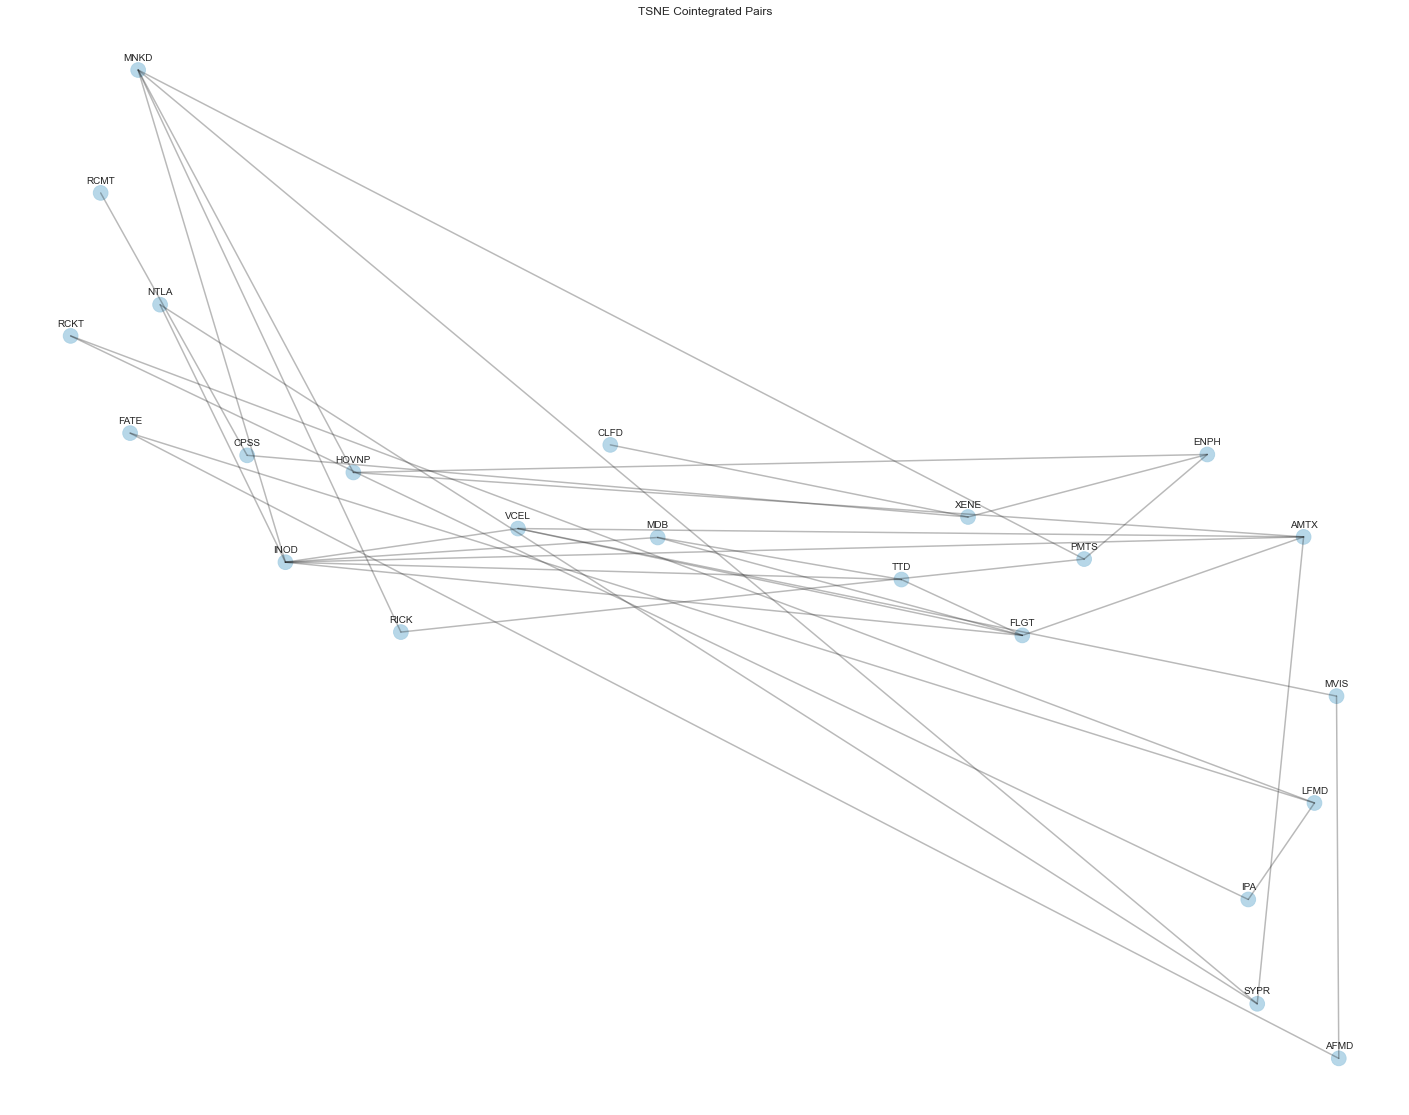

In [113]:
# Preview TSNE
in_pairs_series = clustered_series.loc[pair_unique_assets]
plt.figure(1, figsize=(25, 20))
plt.clf()
plt.axis('off')
for index, pair in df_pair.iterrows():
    ticker1 = pair[0]
    loc1 = df_TSNE.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    ticker2 = pair[0]
    loc2 = df_TSNE.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3)
    
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=215, alpha=0.8, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('TSNE Cointegrated Pairs')

# Show TSNE Plot
for x, y, name in zip(X_tsne[:, 0], X_tsne[:, 1], df_TSNE.index):
    label = name
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha="center")
plt.show()

### Review a Pair for exmaple

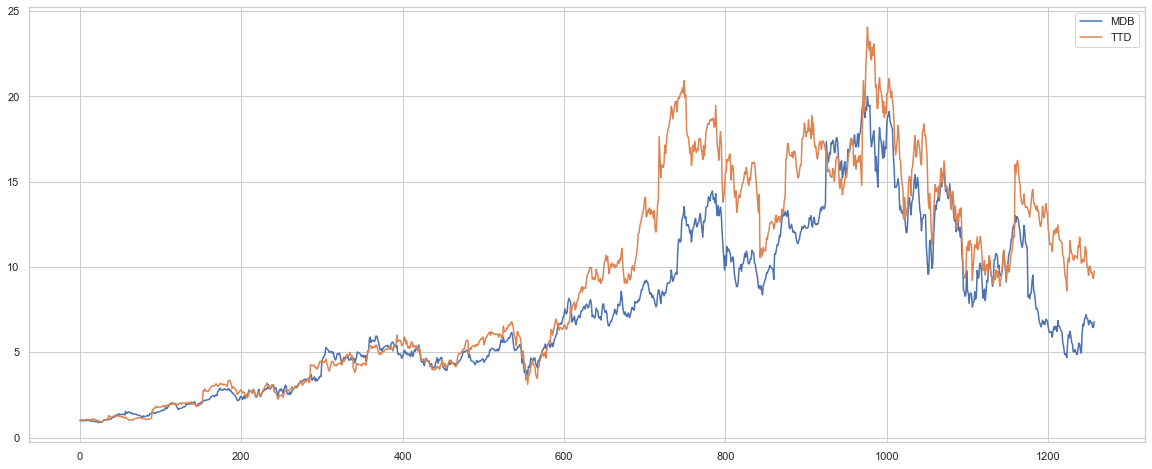

In [114]:

# Plot price comparison for any given assets
asset_1 = "MDB"
asset_2 = "TTD"

# cumulative returns
asset_1_values = data[asset_1].values / data[asset_1].iloc[0].item()
asset_2_values = data[asset_2].values / data[asset_2].iloc[0].item()

plt.figure(1, figsize=(20, 8))
plt.plot(asset_1_values, label = asset_1)
plt.plot(asset_2_values, label = asset_2)
plt.legend()
plt.show()


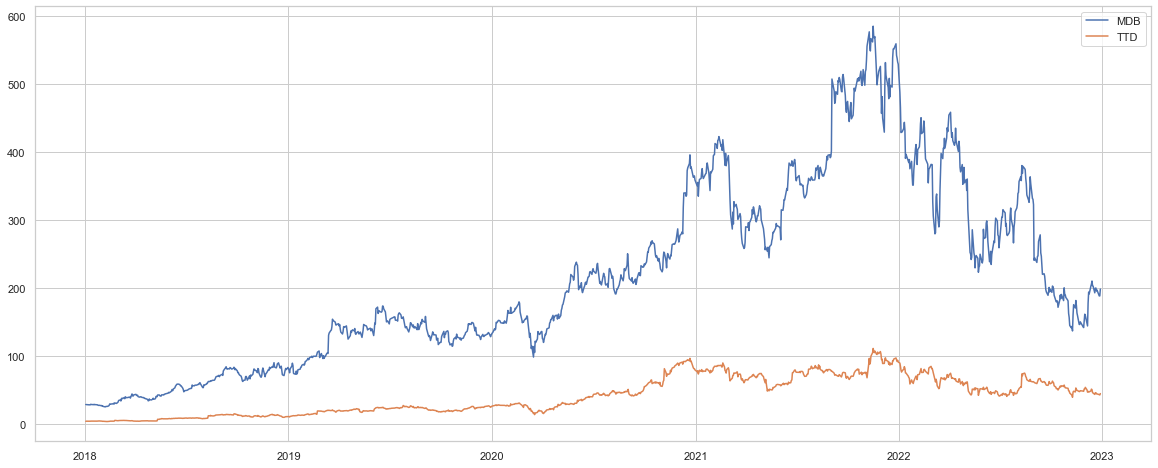

In [115]:

# Plot price comparison for any given assets
asset_1 = "MDB"
asset_2 = "TTD"

# cumulative returns
asset_1_values = data[[asset_1]]
asset_2_values = data[[asset_2]]
#asset_3_values = data[asset_3].values / data[asset_2].iloc[0].item()
plt.figure(1, figsize=(20, 8))
plt.plot(asset_1_values, label = asset_1)
plt.plot(asset_2_values, label = asset_2)
#plt.plot(asset_3_values, label = asset_3)
plt.legend()
plt.show()

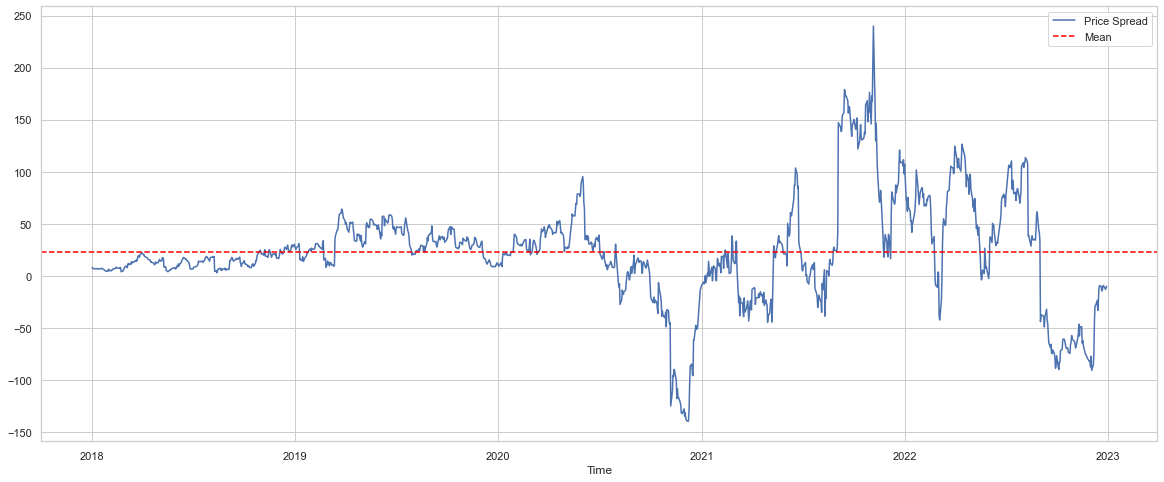

In [116]:
# Plot the Spread between CAMT and RILY
series_1 =  data[[asset_1]]
series_2 = data[[asset_2]]

# get hedge ratio for asset_1 and asset_2
hedge_ratio = df_pair[ (df_pair['base_asset']==asset_1) & (df_pair['compare_asset']==asset_2)]['hedge_ratio'].values
hedge_ratio = float(hedge_ratio)

plt.figure(1, figsize=(20, 8))
#spread
spread = np.subtract (series_1,  hedge_ratio * series_2)
plt.plot(spread)
# Add the mean
plt.axhline(float(spread.mean()), color='red', linestyle='--') 
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean']);
plt.show()

### Stationary Test : Augmented Dickey Fuller

In order to test for stationarity, we need to test for something called a *unit root*. Autoregressive unit root test are based the following hypothesis test:

$$
\begin{aligned}
H_{0} & : \phi =\ 1\ \implies y_{t} \sim I(0) \ | \ (unit \ root) \\
H_{1} & : |\phi| <\ 1\ \implies y_{t} \sim I(0) \ | \ (stationary)  \\
\end{aligned}
$$

It's referred to as a unit root tet because under the null hypothesis, the autoregressive polynominal has a root equal to unity. 


The test statistic is

$$ t_{\phi=1}=\frac{\hat{\phi}-1}{SE(\hat{\phi})}$$


$\hat{\phi}$ is the least square estimate and SE($\hat{\phi}$) is the usual standard error estimate. The test is a one-sided left tail test. If {$y_{t}$} is stationary, then it can be shown that

$$\sqrt{T}(\hat{\phi}-\phi)\xrightarrow[\text{}]{\text{d}}N(0,(1-\phi^{2}))$$

or 

$$\hat{\phi}\overset{\text{A}}{\sim}N\bigg(\phi,\frac{1}{T}(1-\phi^{2}) \bigg)$$

andit follows that $t_{\phi=1}\overset{\text{A}}{\sim}N(0,1).$ However, under the null hypothesis of non-stationarity, the above result gives

$$
\hat{\phi}\overset{\text{A}}{\sim} N(0,1)
$$

The following function will allow us to check for stationarity using the Augmented Dickey Fuller (ADF) test.

In [29]:
def stationarity_test(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')

In [32]:
stationarity_test(spread['MDB'])

p-value = 0.0019274028657511124 The series MDB is likely stationary.


A z-score is the number of standard deviations a datapoint is from the mean. More importantly, the nmber of standard deviations above or below the population mean is from the raw score. The z-score is calculated by the follow:

$$\mathcal{z}_{i}=\frac{x_{i}-\bar{x}}{s} $$

It's an ideal way of analyzing the trend 

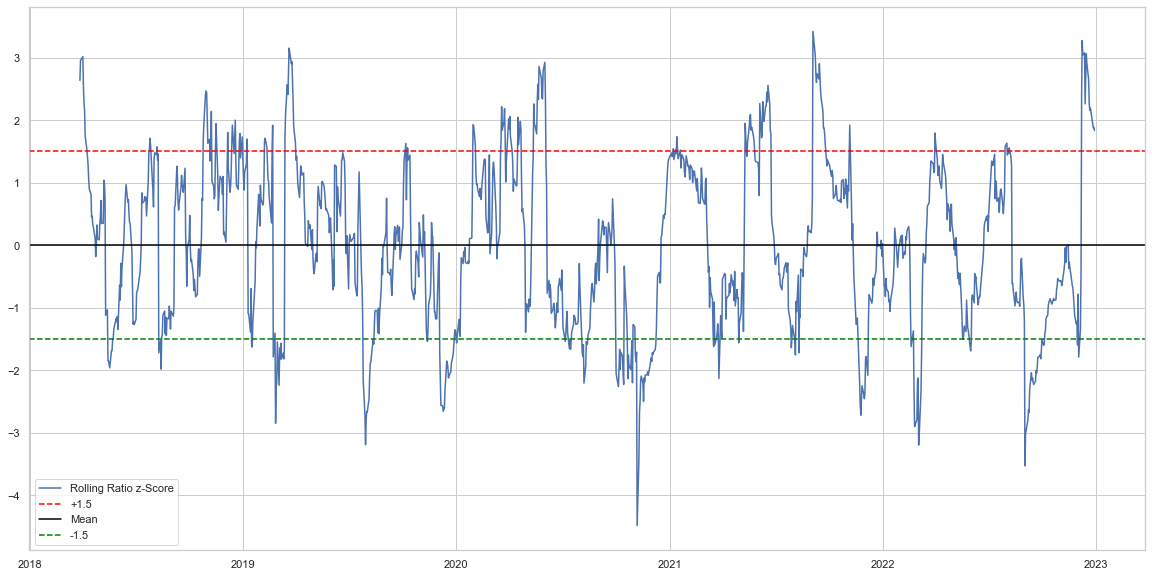

In [117]:
# Plot the ZScore (60 days period)
window = 60
spread_series = spread
mean = spread_series.rolling(center=False, window=window).mean()
std = spread_series.rolling(center=False, window=window).std()
x = spread_series.rolling(center=False, window=1).mean()
z_score = (x - mean) / std
plt.figure(1, figsize=(20, 10))
plt.plot(z_score)
plt.axhline(1.5, color='red',linestyle='--')
plt.axhline(0, color='black')
plt.axhline(-1.5, color='green',linestyle='--')
plt.legend(['Rolling Ratio z-Score', '+1.5', 'Mean', '-1.5'])
plt.show()

By setting two lines placed at the z-score of 1 and -1, we can clearly see that for the most part, any big divergences from the mean eventually converges back. This is exactly what we want for a pairs trading strategy.

### Creating a Model

A standard normal distribution has a mean of 0 and a standard deviation 1. Looking at the plot, it's pretty clear that if the time series moves 1 standard deviation beyond the mean, it tends to revert back towards the mean. Using these models, we can create the following trading signals:

#### Trading Signals
* Buy(1) whenever the z-score is below -1.5, meaning we expect the ratio to increase.
* Sell(-1) whenever the z-score is above 1.5, meaning we expect the ratio to decrease.

In [49]:
test_obs = int(len(data) * .2)
test_obs

251

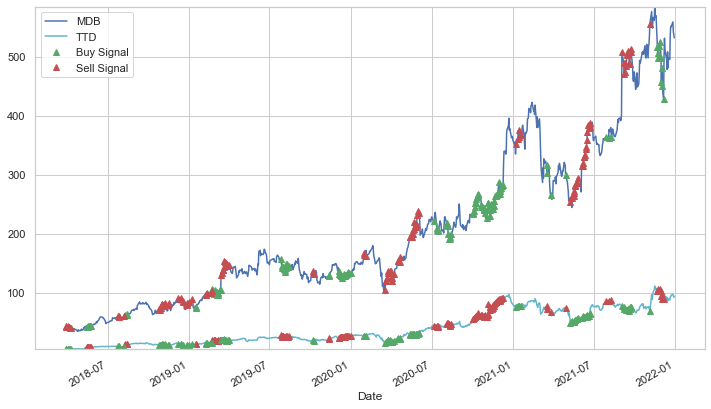

In [118]:
plt.figure(figsize=(12,7))
S1 = data[asset_1].iloc[:-test_obs]
S2 = data[asset_2].iloc[:-test_obs]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buy = 0*S1.copy()
sell = 0*S1.copy()

# when z score is smaller than lower bondary, long stock S1 and short S2
S1.loc[z_score[:-test_obs].values<-1.5].plot(color='g', linestyle='None', marker='^')
S2.loc[z_score[:-test_obs].values<-1.5].plot(color='r', linestyle='None', marker='^')

# when z score is larger than uppper bondary, short stock S1 and long S2
S1.loc[z_score[:-test_obs].values>1.5].plot(color='r', linestyle='None', marker='^')
S2.loc[z_score[:-test_obs].values>1.5].plot(color='g', linestyle='None', marker='^')

buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))

plt.legend(['MDB', 'TTD', 'Buy Signal', 'Sell Signal'])
plt.show()

### Conclusion

When sifting through heavy amounts of price data, it can be tricky to find potentially great pairs to trade quickly. Equally, having pairs which match likeness in terms of price behaviour including volatility, might be advantageous and ensure better risk management.

By clustering using K-Means, it's possible to quickly identify a list of trading pairs which resemble a likeness in respect to returns versus volatility. Helping to refine our conintegrated statistical arbitrage trading strategy even further.

In this notebook I use one pair for example. In real life, in order to diversify the portfolio, multiple pairs are used.